In [ ]:
# Import libraries
import torch
import warnings
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')




In [ ]:
# HYPERPARAMS
num_epochs = 20
batch_size = 128
lr = 0.01

# CONSTANTS
NUM_CLASSES = 10
DATA_MEAN = (0.1307,)
DATA_STD = (0.3081,)

# cuda availability
cuda_available = torch.cuda.is_available()
device = "cuda" if cuda_available else "cpu"

In [ ]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), # 28x28x1 -> 28x28x16 | RF = 3
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True), 
            nn.Conv2d(16, 32, 3, padding=1), # 28x28x16 -> 28x28x32 | RF = 5
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # 28x28x32 -> 14x14x32 | RF = 10
            )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 8, 1), # 14x14x32 -> 14x14x8 | RF = 10
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 16, 3, padding=1), # 14x14x8 -> 14x14x16 | RF = 12
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, 3, padding=1), # 14x14x16 -> 14x14x32 | RF = 14
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2), # 14x14x32 -> 7x7x32 | RF = 28
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(32, 8, 1), # 7x7x32 -> 7x7x8| RF = 28
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 16, 3), # 7x7x8 -> 7x7x16 | RF = 30
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Conv2d(16, 32, 3), # 7x7x16 -> 7x7x32 | RF = 32
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1)), # 7x7x32 -> 1x1x32 | RF = 32 || Global average pooling
            nn.Dropout(p=0.15)
            )
        self.classifier = nn.Sequential(
            nn.Linear(32, NUM_CLASSES),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_block1(x) # First conv block
        x = self.conv_block2(x) # Second conv block
        x = self.conv_block3(x) # Third conv block
        x = x.view(-1, 32) # Flatten the output of last conv block
        output = self.classifier(x)

        return output

In [ ]:
!pip -q install torchsummary
from torchsummary import summary
model = MNISTNet().to(device)

# print model summary
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 32, 28, 28]           4,640
       BatchNorm2d-5           [-1, 32, 28, 28]              64
              ReLU-6           [-1, 32, 28, 28]               0
         MaxPool2d-7           [-1, 32, 14, 14]               0
            Conv2d-8            [-1, 8, 14, 14]             264
       BatchNorm2d-9            [-1, 8, 14, 14]              16
             ReLU-10            [-1, 8, 14, 14]               0
           Conv2d-11           [-1, 16, 14, 14]           1,168
      BatchNorm2d-12           [-1, 16, 14, 14]              32
             ReLU-13           [-1, 16, 14, 14]               0
           Conv2d-14           [-1, 32,

Total number of parameters used in the mode: **17498**

In [ ]:
# Initialize transformation, datasets, and loaders
classes = range(10)

train_transform = transforms.Compose(
                    [
                    transforms.ToTensor(),
                    transforms.Normalize(DATA_MEAN, DATA_STD),
                    ])

test_transform = transforms.Compose(
                    [
                    transforms.ToTensor(),
                    transforms.Normalize(DATA_MEAN, DATA_STD),
                    ])


# Download MNIST Training
train_set = datasets.MNIST(root= './data',
                                       train= True,
                                       download= True,
                                       transform= transforms.Compose([
                                                                      transforms.ToTensor()
                                       ]))
# Download MNIST TEST
test_set = datasets.MNIST(root='./data',
                                      train=False,
                                      download=True,
                                      transform=transforms.Compose([
                                                                    transforms.ToTensor()
                                      ]))

torch.manual_seed(1) #Set seed for reproducibility
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda_available else {}

# Load MNIST Train Data Loader
train_loader = torch.utils.data.DataLoader(train_set,
                                            batch_size= batch_size,
                                            shuffle= True,
                                            drop_last=True, # Drop the last batch if total size is not divisble by batch size
                                           **kwargs)

# Load MNIST Test Data Loader
test_loader = torch.utils.data.DataLoader(test_set, 
                                          batch_size=batch_size, 
                                          shuffle=True,
                                          drop_last=True
                                          **kwargs)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


In [ ]:
# Check Data for Each Class for train set| number of examples

print("Class & Data For Training Set : ")
print(train_set.targets.unique())
print(train_set.targets.bincount())
print()

# Check Data for Each Class for test set| number of examples

print("Class & Data For Test Set : ")
print(test_set.targets.unique())
print(test_set.targets.bincount())


Class & Data For Training Set : 
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])

Class & Data For Test Set : 
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_image(image, title: str="Class label"):
    """
    This function essentially takes in normalized tensors and the
    Un-normalize them and display the image as output.

    Args:
    ----
    image: Image which we want to plot.
    title: Label for that image.
    """
    image = image.numpy().transpose((1, 2, 0)) # (C, H, W) --> (H, W, C)
    # Convert mean and std to numpy array
    mean = np.asarray(DATA_MEAN)
    std = np.asarray(DATA_STD)
    # unnormalize the image
    image = std * image + mean
    image = np.clip(image, 0, 1)
    
    print(title)
    fig = plt.figure() # Create a new figure
    fig.set_figheight(15)
    fig.set_figwidth(15)
    ax = fig.add_subplot(111)
    ax.axis("off") # Sqitch off the axis
    ax.imshow(image)

['0', '3', '8', '9', '2', '8', '0', '1', '0', '2', '4', '5', '5', '6', '0', '2', '7', '6', '4', '3', '8', '6', '1', '7', '6', '0', '4', '7', '2', '7', '9', '1', '9', '7', '8', '2', '0', '3', '4', '4', '9', '7', '5', '6', '4', '9', '8', '6', '0', '7', '8', '6', '5', '5', '6', '9', '8', '0', '3', '4', '0', '1', '9', '5', '9', '7', '5', '9', '7', '7', '8', '1', '2', '7', '6', '8', '5', '6', '9', '8', '1', '7', '0', '9', '2', '7', '5', '3', '8', '5', '1', '7', '9', '4', '7', '4', '5', '7', '3', '4', '4', '6', '9', '9', '0', '3', '9', '7', '1', '4', '3', '7', '3', '0', '6', '1', '1', '3', '7', '2', '5', '4', '1', '1', '2', '6', '7', '7']


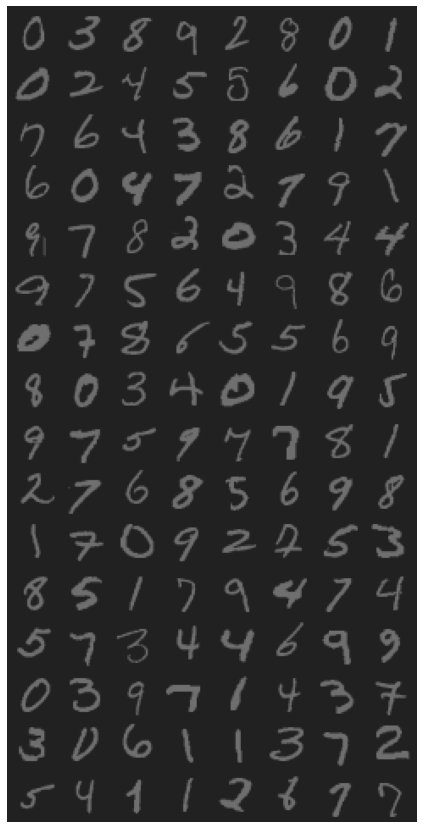

In [ ]:
# Iteratre over and get 1 batch of training data
data, targets = next(iter(train_loader))

# make_grid takes all tensors(batch) and joins them into a single big tensor image (almost)
batch_grid = torchvision.utils.make_grid(data) 

display_image(batch_grid, title=[str(cls.item()) for cls in targets])

Class label: 3


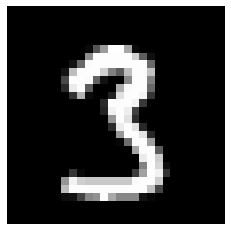

In [ ]:
# Drawing a single sample from the dataset
images, labels = next(iter(train_loader))
images[0].data.shape

# Plot a single image and its label.
print(f"Class label: {classes[labels[0]]}")
plt.axis("off")
plt.imshow(images[0].data.reshape((28,28)), cmap="gray");

In [ ]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer):
    """
    Model training function.
    
    Args
    ----
    model : model that we want to train.
    device: device on which we want to train our model (cuda or cpu)
    train_loader : training dataset data loader.
    optimizer: what optimization method we want to use for training our model.
    """
    model.train()
    train_loss = 0
    train_acc = 0
    correct = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device) # Put data to device
        optimizer.zero_grad() # set gradients to 0
        
        output = model(data) # Forward pass
        
        loss = F.nll_loss(output, target) # Calculate loss
        train_loss += loss
        loss.backward() # Backpropogate
        
        optimizer.step() # Update parameters

        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max logit value
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        pbar.set_description(desc= f'loss={round(loss.item(), 7)} batch_id={batch_idx}')

    train_loss /= len(train_loader.dataset)
    train_acc = (correct/len(train_loader.dataset)) * 100

    print(f"\n\nTrain Accuracy: {round(train_acc,4)} % \t Train Loss: {round(train_loss.item(),4)}")

    return train_loss, train_acc
def test(model, device, test_loader):
    """
    Model testing function to test the performance of our trained model on the test data.
    
    Args
    ----
    model : model that we want to test.
    device: device on which we want to train our model (cuda or cpu)
    test_loader : testing dataset data loader to test our model on.
    """
    model.eval() # Put model in evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max logit
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc =  (correct / len(test_loader.dataset)) * 100

    print(f"\nTest Accuracy: {round(test_acc,4)} % \t Test Loss: {round(test_loss,4)}\n")
    print(f"Number of correct prediction in test set: {correct}/{len(test_loader.dataset)}")

    return test_loss, test_acc

In [ ]:

# Initialize the model
model = MNISTNet().to(device)

# Using Adam optimizer with inital learning rate as 0.01
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)

# To accumulate training and testing loss
train_losses = []
test_losses = []

# To accumulate training and testing accuracies
train_acc = []
test_acc = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}:")
    print("="*20)
    loss, acc = train(model, device, train_loader, optimizer)
    train_losses.append(loss)
    train_acc.append(acc)

    scheduler.step()
    
    loss, acc = test(model, device, test_loader)
    test_losses.append(loss)
    test_acc.append(acc)
    print("+"*20)


  0%|          | 0/468 [00:00<?, ?it/s]


Epoch 1:


loss=0.0778517 batch_id=467: 100%|██████████| 468/468 [00:13<00:00, 34.55it/s]



Train Accuracy: 92.07 % 	 Train Loss: 0.0019



  0%|          | 0/468 [00:00<?, ?it/s]


Test Accuracy: 98.59 % 	 Test Loss: 0.0004

Number of correct prediction in test set: 9859/10000
++++++++++++++++++++

Epoch 2:


loss=0.0857671 batch_id=467: 100%|██████████| 468/468 [00:13<00:00, 33.96it/s]



Train Accuracy: 97.53 % 	 Train Loss: 0.0006



  0%|          | 0/468 [00:00<?, ?it/s]


Test Accuracy: 98.58 % 	 Test Loss: 0.0004

Number of correct prediction in test set: 9858/10000
++++++++++++++++++++

Epoch 3:


loss=0.0484976 batch_id=467: 100%|██████████| 468/468 [00:13<00:00, 34.40it/s]



Train Accuracy: 98.1283 % 	 Train Loss: 0.0005



  0%|          | 0/468 [00:00<?, ?it/s]


Test Accuracy: 98.27 % 	 Test Loss: 0.0004

Number of correct prediction in test set: 9827/10000
++++++++++++++++++++

Epoch 4:


loss=0.0227978 batch_id=467: 100%|██████████| 468/468 [00:13<00:00, 33.79it/s]



Train Accuracy: 98.1333 % 	 Train Loss: 0.0005



  0%|          | 0/468 [00:00<?, ?it/s]


Test Accuracy: 98.63 % 	 Test Loss: 0.0004

Number of correct prediction in test set: 9863/10000
++++++++++++++++++++

Epoch 5:


loss=0.0122312 batch_id=467: 100%|██████████| 468/468 [00:13<00:00, 34.61it/s]



Train Accuracy: 98.36 % 	 Train Loss: 0.0004



  0%|          | 0/468 [00:00<?, ?it/s]


Test Accuracy: 98.59 % 	 Test Loss: 0.0004

Number of correct prediction in test set: 9859/10000
++++++++++++++++++++

Epoch 6:


loss=0.0955839 batch_id=467: 100%|██████████| 468/468 [00:13<00:00, 34.05it/s]



Train Accuracy: 98.4817 % 	 Train Loss: 0.0004



  0%|          | 0/468 [00:00<?, ?it/s]


Test Accuracy: 98.19 % 	 Test Loss: 0.0005

Number of correct prediction in test set: 9819/10000
++++++++++++++++++++

Epoch 7:


loss=0.0063186 batch_id=467: 100%|██████████| 468/468 [00:13<00:00, 33.77it/s]



Train Accuracy: 98.4917 % 	 Train Loss: 0.0004



  0%|          | 0/468 [00:00<?, ?it/s]


Test Accuracy: 98.67 % 	 Test Loss: 0.0003

Number of correct prediction in test set: 9867/10000
++++++++++++++++++++

Epoch 8:


loss=0.0293866 batch_id=467: 100%|██████████| 468/468 [00:13<00:00, 34.12it/s]



Train Accuracy: 98.68 % 	 Train Loss: 0.0003



  0%|          | 0/468 [00:00<?, ?it/s]


Test Accuracy: 99.02 % 	 Test Loss: 0.0002

Number of correct prediction in test set: 9902/10000
++++++++++++++++++++

Epoch 9:


loss=0.0362401 batch_id=467: 100%|██████████| 468/468 [00:13<00:00, 33.43it/s]



Train Accuracy: 98.565 % 	 Train Loss: 0.0003



  0%|          | 0/468 [00:00<?, ?it/s]


Test Accuracy: 99.08 % 	 Test Loss: 0.0002

Number of correct prediction in test set: 9908/10000
++++++++++++++++++++

Epoch 10:


loss=0.095508 batch_id=467: 100%|██████████| 468/468 [00:13<00:00, 33.85it/s]



Train Accuracy: 98.665 % 	 Train Loss: 0.0003



  0%|          | 0/468 [00:00<?, ?it/s]


Test Accuracy: 99.08 % 	 Test Loss: 0.0002

Number of correct prediction in test set: 9908/10000
++++++++++++++++++++

Epoch 11:


loss=0.011568 batch_id=467: 100%|██████████| 468/468 [00:13<00:00, 33.77it/s]



Train Accuracy: 99.22 % 	 Train Loss: 0.0002



  0%|          | 0/468 [00:00<?, ?it/s]


Test Accuracy: 99.47 % 	 Test Loss: 0.0002

Number of correct prediction in test set: 9947/10000
++++++++++++++++++++

Epoch 12:


loss=0.0330705 batch_id=467: 100%|██████████| 468/468 [00:13<00:00, 33.59it/s]



Train Accuracy: 99.355 % 	 Train Loss: 0.0001



  0%|          | 0/468 [00:00<?, ?it/s]


Test Accuracy: 99.47 % 	 Test Loss: 0.0001

Number of correct prediction in test set: 9947/10000
++++++++++++++++++++

Epoch 13:


loss=0.0067421 batch_id=467: 100%|██████████| 468/468 [00:13<00:00, 34.29it/s]



Train Accuracy: 99.4183 % 	 Train Loss: 0.0001



  0%|          | 0/468 [00:00<?, ?it/s]


Test Accuracy: 99.48 % 	 Test Loss: 0.0001

Number of correct prediction in test set: 9948/10000
++++++++++++++++++++

Epoch 14:


loss=0.0126215 batch_id=467: 100%|██████████| 468/468 [00:13<00:00, 33.53it/s]



Train Accuracy: 99.41 % 	 Train Loss: 0.0001



  0%|          | 0/468 [00:00<?, ?it/s]


Test Accuracy: 99.51 % 	 Test Loss: 0.0002

Number of correct prediction in test set: 9951/10000
++++++++++++++++++++

Epoch 15:


loss=0.047155 batch_id=467: 100%|██████████| 468/468 [00:13<00:00, 33.77it/s]



Train Accuracy: 99.3917 % 	 Train Loss: 0.0001



  0%|          | 0/468 [00:00<?, ?it/s]


Test Accuracy: 99.51 % 	 Test Loss: 0.0002

Number of correct prediction in test set: 9951/10000
++++++++++++++++++++

Epoch 16:


loss=0.0089742 batch_id=467: 100%|██████████| 468/468 [00:14<00:00, 33.42it/s]




Train Accuracy: 99.4917 % 	 Train Loss: 0.0001


  0%|          | 0/468 [00:00<?, ?it/s]


Test Accuracy: 99.56 % 	 Test Loss: 0.0001

Number of correct prediction in test set: 9956/10000
++++++++++++++++++++

Epoch 17:


loss=0.0033094 batch_id=467: 100%|██████████| 468/468 [00:13<00:00, 33.53it/s]



Train Accuracy: 99.5167 % 	 Train Loss: 0.0001



  0%|          | 0/468 [00:00<?, ?it/s]


Test Accuracy: 99.56 % 	 Test Loss: 0.0001

Number of correct prediction in test set: 9956/10000
++++++++++++++++++++

Epoch 18:


loss=0.0062471 batch_id=467: 100%|██████████| 468/468 [00:13<00:00, 33.67it/s]



Train Accuracy: 99.535 % 	 Train Loss: 0.0001



  0%|          | 0/468 [00:00<?, ?it/s]


Test Accuracy: 99.55 % 	 Test Loss: 0.0001

Number of correct prediction in test set: 9955/10000
++++++++++++++++++++

Epoch 19:


loss=0.0044553 batch_id=467: 100%|██████████| 468/468 [00:14<00:00, 33.25it/s]



Train Accuracy: 99.515 % 	 Train Loss: 0.0001



  0%|          | 0/468 [00:00<?, ?it/s]


Test Accuracy: 99.57 % 	 Test Loss: 0.0001

Number of correct prediction in test set: 9957/10000
++++++++++++++++++++

Epoch 20:


loss=0.0011424 batch_id=467: 100%|██████████| 468/468 [00:13<00:00, 33.44it/s]



Train Accuracy: 99.555 % 	 Train Loss: 0.0001



Test Accuracy: 99.54 % 	 Test Loss: 0.0001

Number of correct prediction in test set: 9954/10000
++++++++++++++++++++


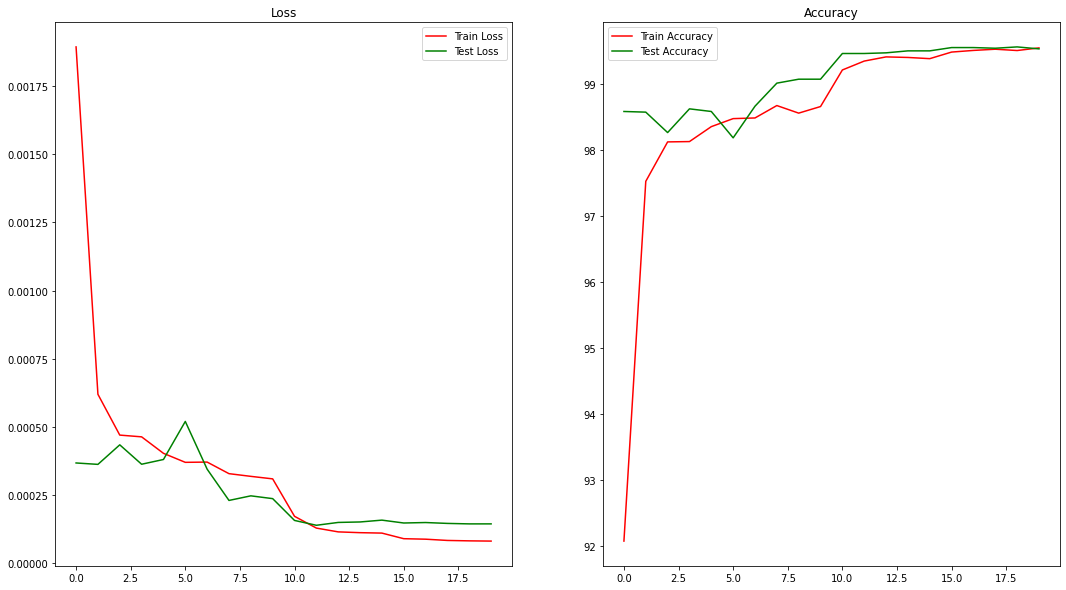

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,10))

# Plot loss values over the epochs
ax1 = ax[0]
ax1.set_title("Loss")
ax1.plot(train_losses, color="red", label="Train Loss")
ax1.plot(test_losses, color="green", label="Test Loss")
ax1.legend()

# Plot accuracies over the epochs
ax2 = ax[1]
ax2.set_title("Accuracy")
ax2.plot(train_acc, color="red", label="Train Accuracy")
ax2.plot(test_acc, color="green", label="Test Accuracy")
ax2.legend()

plt.show()
